In [35]:
import pandas as pd
import seaborn as sns
from sklearn.mixture import GaussianMixture
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [36]:
country_dir = "country_dir"

country_dfs = ["depression_by_age", "depression_by_education", "depression_by_sex", "depression_suicide_rates", "illness_rates"]

# Dictionary to hold DataFrames
dataframes = {}

# Loop through files and assign DataFrames to dictionary
for filename, key in zip(os.listdir(country_dir), country_dfs):
    f = os.path.join(country_dir, filename)
    dataframes[key] = pd.read_csv(f)

# Access DataFrames by name
depression_by_age = dataframes["depression_by_age"]
depression_by_education = dataframes["depression_by_education"]
depression_by_sex = dataframes["depression_by_sex"]
depression_suicide_rates = dataframes["depression_suicide_rates"]
illness_rates = dataframes["illness_rates"]

In [37]:
depression_suicide_rates['year'] = depression_suicide_rates['year'].str.replace(r'\bBCE?\b', '', regex=True).str.strip()

In [38]:
gdp_df = pd.read_csv('country_dir/gdp.csv')
df_merge = pd.merge(
    depression_suicide_rates,
    gdp_df,
    how='left',
    left_on='entity',
    right_on='Country'
)

df_merge = df_merge[df_merge['entity'].notna()]
df_merge = df_merge.drop(['Country', 'Year'], axis=1)
df_merge['Log population'] = np.log(df_merge['population'])
df_merge['Log Millions'] = np.log(df_merge['Millions'].str.replace(r',', '', regex=True).str.strip().astype(float))
df_merge.drop(['Millions', 'population'], axis=1, inplace=True)
country_suicide_rates = df_merge.drop(['code', 'year'], axis=1).groupby(["entity"]).mean()
country_suicide_rates.columns = ['suicide_rate', 'depression_rate', 'log_population', 'log_gdp']
country_suicide_rates.dropna(subset=['suicide_rate', 'depression_rate', 'log_population', 'log_gdp'], inplace=True)
country_suicide_rates.describe()

,suicide_rate,depression_rate,log_population,log_gdp
count,167.000000,167.000000,167.000000,167.000000
mean,12.029125,3353.958966,14.205477,10.863022
std,8.168492,621.554711,2.013884,2.259012
min,2.565533,2102.317356,8.953785,5.631319
25%,6.546849,2918.420992,12.915866,9.553295
50%,10.471898,3365.383949,14.553025,10.789929
75%,14.960367,3680.249803,15.456902,12.485574
max,73.811155,5954.307590,20.111359,17.124629


In [39]:
df_merge.head()

,entity,code,year,"suicide rate (deaths per 100,000 individuals)","depressive disorder rates (number suffering per 100,000)",Log population,Log Millions
0,Afghanistan,AFG,1800,NaN,NaN,15.003354,9.582053
1,Afghanistan,AFG,1801,NaN,NaN,15.003354,9.582053
2,Afghanistan,AFG,1802,NaN,NaN,15.003354,9.582053
3,Afghanistan,AFG,1803,NaN,NaN,15.003354,9.582053
4,Afghanistan,AFG,1804,NaN,NaN,15.003354,9.582053


C:\Users\rache\miniconda3\envs\S486\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


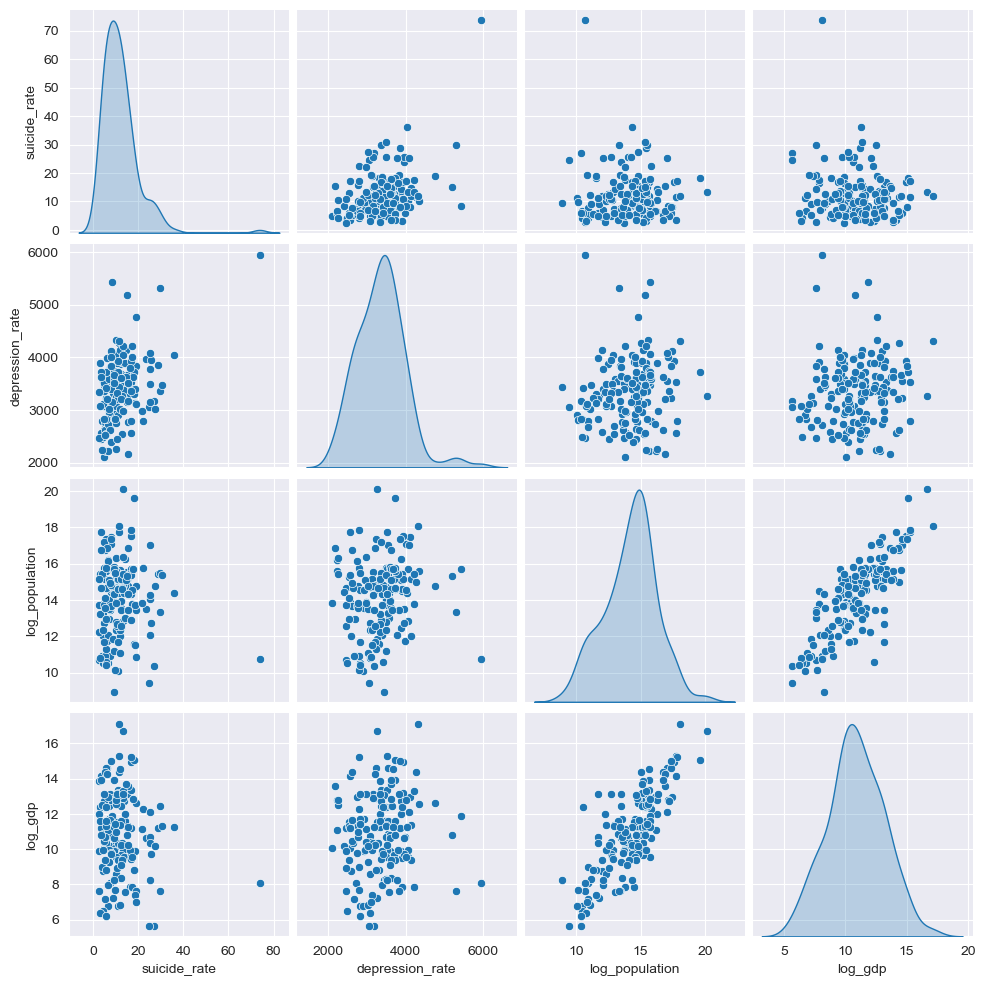

In [40]:
sns.pairplot(country_suicide_rates[['suicide_rate', 'depression_rate', 'log_population', 'log_gdp']], diag_kind="kde")

In [41]:
gmm = GaussianMixture(n_components=4, random_state=486)
gmm.fit(country_suicide_rates)

# Calculate log probabilities for each data point
log_probs = gmm.score_samples(country_suicide_rates)

# Set a threshold (e.g., 5th percentile)
threshold = np.percentile(log_probs, 2.5)

# Identify outliers
country_suicide_rates['log_prob'] = log_probs
country_suicide_rates['outlier'] = log_probs < threshold

# Filter out the outliers
df_without_outliers = country_suicide_rates[~country_suicide_rates['outlier']].drop(columns=['log_prob', 'outlier'])

# Display the reduced DataFrame
print(df_without_outliers)

                suicide_rate  depression_rate  log_population    log_gdp
entity                                                                  
Afghanistan        10.305521      4058.931398       15.701120   9.582053
Albania             4.910782      2102.317356       13.814576  10.042279
Algeria             4.817725      3479.935759       15.752063  12.387975
American Samoa      6.632924      2828.939364       10.511312   6.769642
Andorra             9.305881      3431.433099        8.953785   8.223539
...                      ...              ...             ...        ...
Uruguay            15.374334      3174.434763       13.434036  11.254683
Uzbekistan          9.917816      2828.800882       15.496159  11.417396
Vanuatu            19.276240      3104.336661       10.865241   7.026702
Zambia             15.486226      3512.648435       14.311728  10.245751
Zimbabwe           27.566154      3025.090927       14.785254  10.186343

[162 rows x 4 columns]


C:\Users\rache\miniconda3\envs\S486\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


C:\Users\rache\miniconda3\envs\S486\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rache\miniconda3\envs\S486\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\rache\miniconda3\envs\S486\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rache\miniconda3\envs\S486\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a mem

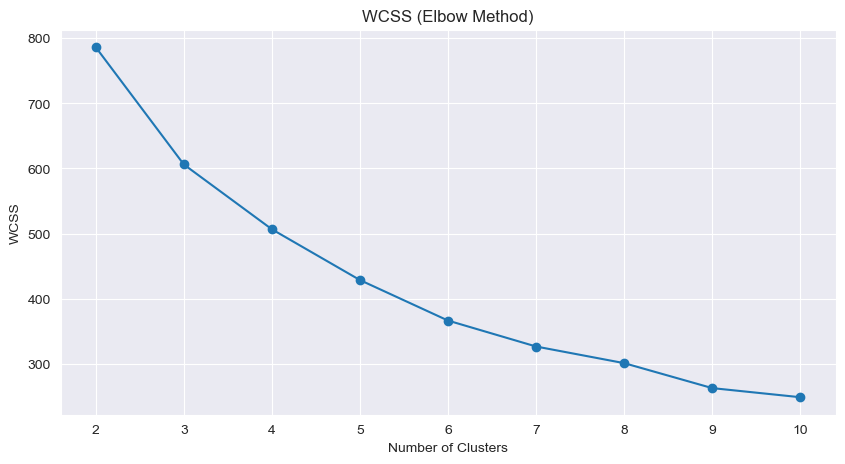

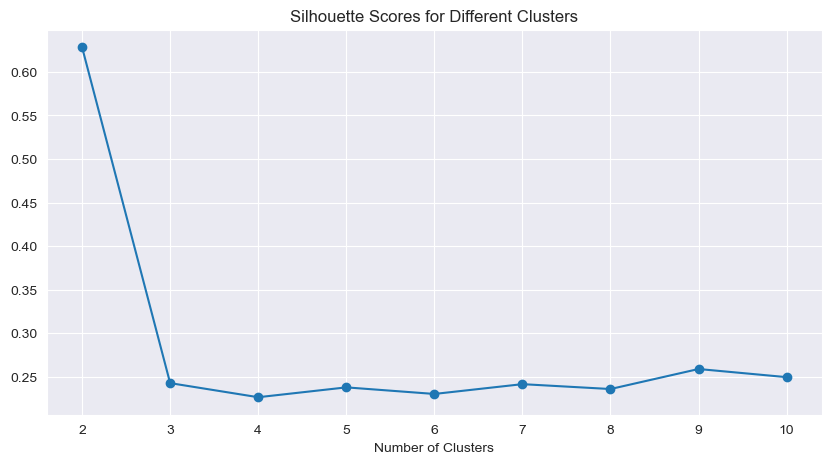

In [42]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(country_suicide_rates)

wcss = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(scaled_features)

    # WCSS
    wcss.append(kmeans.inertia_)

    # Silhouette Score
    score = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(score)

# Plot WCSS (Elbow Method)
plt.figure(figsize=(10, 5))
plt.plot(k_range, wcss, marker='o')
plt.title('WCSS (Elbow Method)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.title('Silhouette Scores for Different Clusters')
plt.show()

C:\Users\rache\miniconda3\envs\S486\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\rache\miniconda3\envs\S486\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


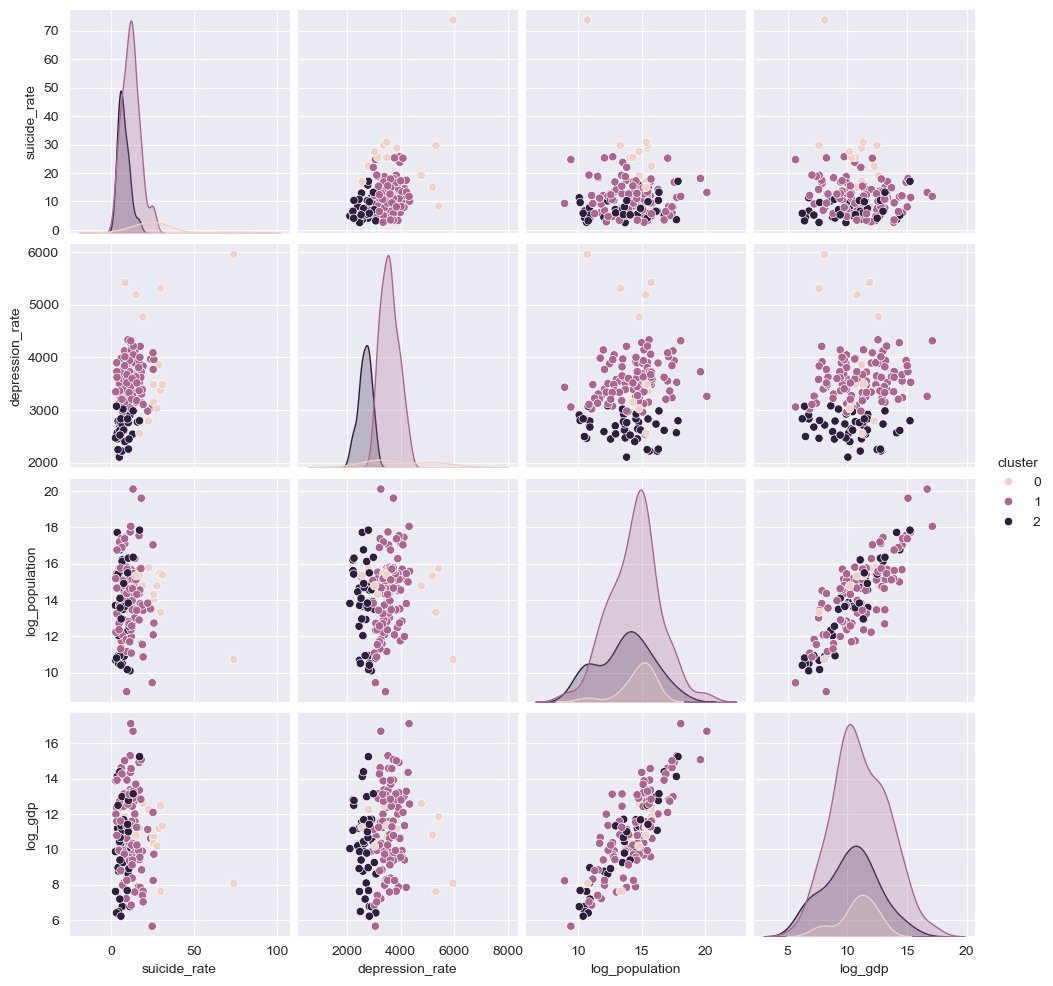

In [43]:
gmm_reduced = GaussianMixture(n_components=3, random_state=486)
gmm_reduced.fit(df_without_outliers)
df_without_outliers['cluster'] = gmm_reduced.predict(df_without_outliers)

sns.pairplot(df_without_outliers, hue='cluster', diag_kind="kde")

In [44]:
print(df_without_outliers[df_without_outliers['cluster'] == 0])

                  suicide_rate  depression_rate  log_population    log_gdp  \
entity                                                                       
Belarus              28.752500      3856.995149       15.456363  11.182439   
Finland              19.115476      4770.389262       14.794494  12.612162   
Greenland            73.811155      5954.307590       10.739188   8.082035   
Hungary              22.441278      2789.018957       15.772735  12.266174   
Kazakhstan           29.738463      3365.383949       15.479472  12.473888   
Latvia               25.496611      3484.584065       14.068189  10.683433   
Lesotho              29.724027      5313.937311       13.326557   7.623661   
Morocco               8.346561      5423.930278       15.736797  11.857291   
Papua New Guinea     25.516646      3146.037111       14.300192  10.339563   
Serbia               17.068240      2556.730913       15.356508  11.227735   
Sri Lanka            30.846508      3480.789785       15.379780 

Looking now at depression by age with the country data

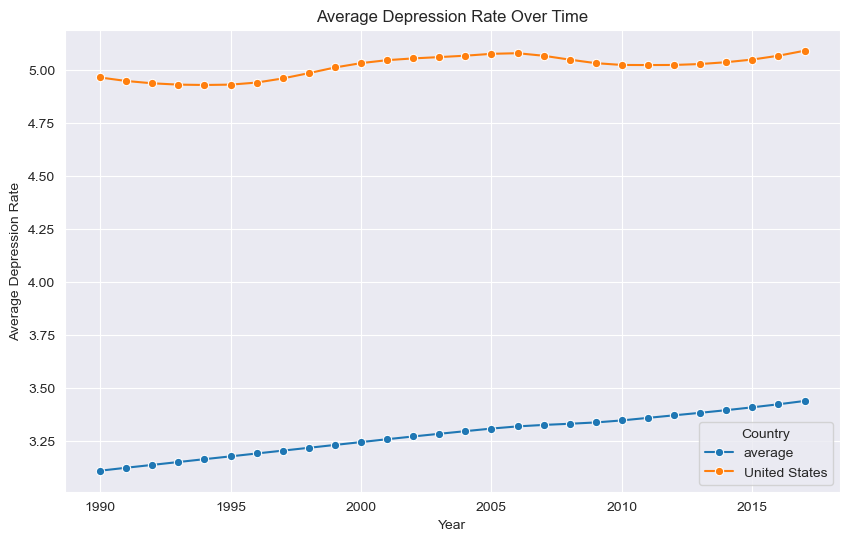

In [45]:
avg_depression_rate = depression_by_age.groupby('year')['all_ages'].mean().reset_index()
avg_depression_rate['entity'] = 'average'

countries_of_interest = depression_by_age[depression_by_age['entity'].isin(['United States'])]

plot_data = pd.concat([avg_depression_rate, countries_of_interest])

plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_data, x='year', y='all_ages', hue="entity", marker='o')
plt.title('Average Depression Rate Over Time')
plt.xlabel('Year')
plt.ylabel('Average Depression Rate')
plt.legend(title='Country')
plt.grid(True)
plt.show()

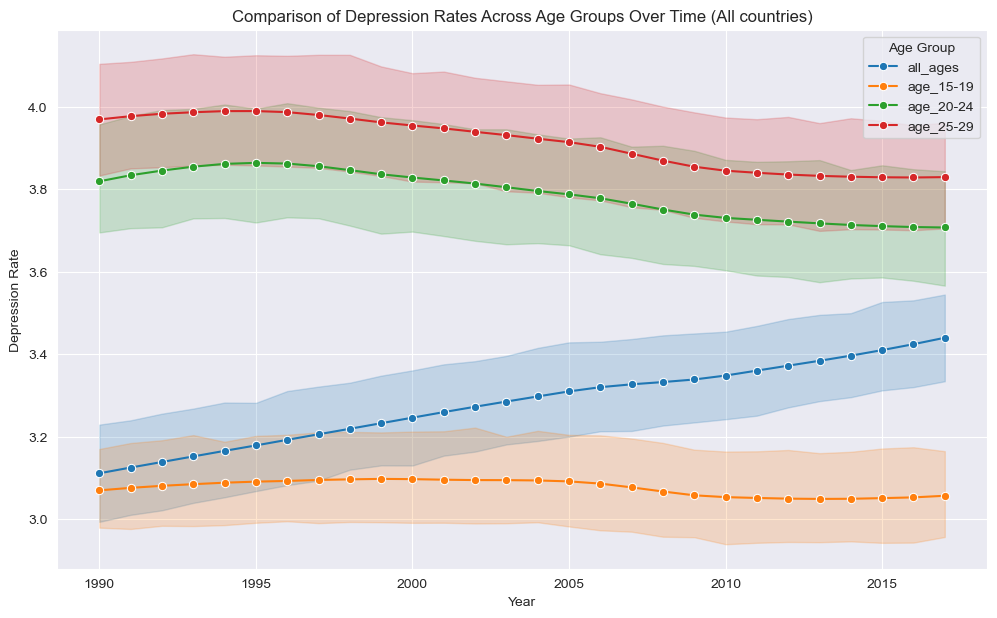

In [46]:
age_columns = ['all_ages', 'age_15-19', 'age_20-24', 'age_25-29'] 
df_melted = pd.melt(depression_by_age, id_vars='year', value_vars=age_columns, 
                    var_name='AgeGroup', value_name='DepressionRate')

plt.figure(figsize=(12, 7))
sns.lineplot(data=df_melted, x='year', y='DepressionRate', hue='AgeGroup', marker='o')
plt.title('Comparison of Depression Rates Across Age Groups Over Time (All countries)')
plt.xlabel('Year')
plt.ylabel('Depression Rate')
plt.grid(True)
plt.legend(title='Age Group')
plt.show()

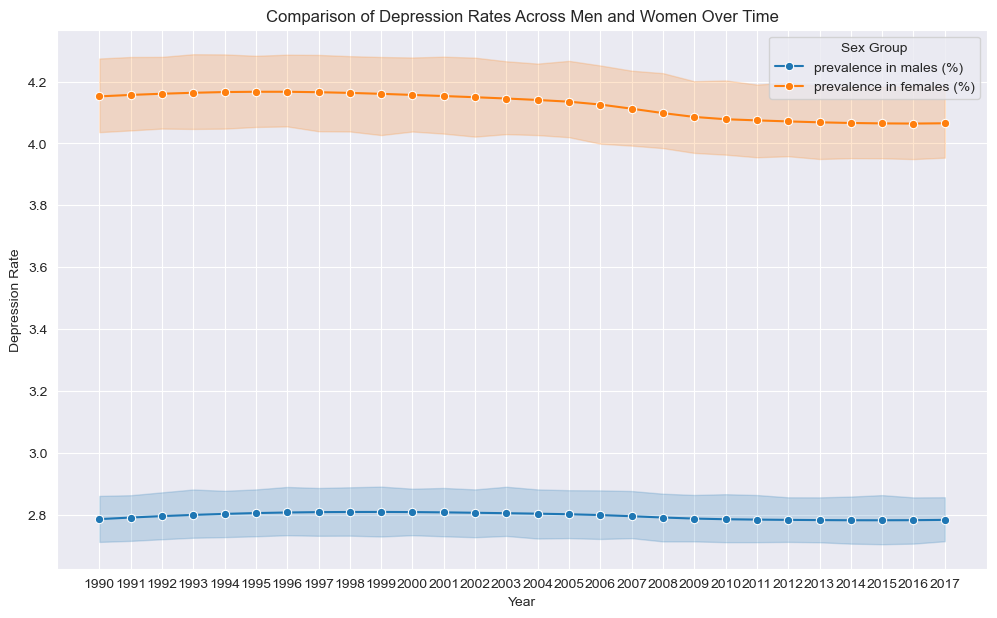

In [47]:
depression_by_sex = depression_by_sex.dropna()
sex_columns = ['prevalence in males (%)', 'prevalence in females (%)']
df_melted = pd.melt(depression_by_sex, id_vars='year', value_vars=sex_columns, 
                    var_name='SexGroup', value_name='DepressionRate')

# Step 2: Plot the data
plt.figure(figsize=(12, 7))
sns.lineplot(data=df_melted, x='year', y='DepressionRate', hue='SexGroup', marker='o')
plt.title('Comparison of Depression Rates Across Men and Women Over Time')
plt.xlabel('Year')
plt.ylabel('Depression Rate')
plt.grid(True)
plt.legend(title='Sex Group')
plt.show()

Mental Health Care Analysis

In [48]:
df = pd.read_csv("Mental_Health_Care_in_the_Last_4_Weeks.csv")

In [49]:
df['Value'] = df.groupby(['Indicator', 'Group', 'Subgroup', 'State'])['Value'].transform(lambda x: x.fillna(x.mean()))
df = df.drop(['LowCI', 'HighCI'], axis=1)

df['Time Period Start Date'] = pd.to_datetime(df['Time Period Start Date'])
df['Time Period End Date'] = pd.to_datetime(df['Time Period End Date'])

df.head()

,Indicator,Group,State,Subgroup,Time Period Start Date,Time Period End Date,Value
0,Needed Counseling or Therapy But Did Not Get I...,By Age,United States,18 - 29 years,2020-08-19,2020-08-31,15.6
1,Needed Counseling or Therapy But Did Not Get I...,By Age,United States,30 - 39 years,2020-08-19,2020-08-31,12.9
2,Needed Counseling or Therapy But Did Not Get I...,By Age,United States,40 - 49 years,2020-08-19,2020-08-31,10.0
3,Needed Counseling or Therapy But Did Not Get I...,By Age,United States,50 - 59 years,2020-08-19,2020-08-31,7.7
4,Needed Counseling or Therapy But Did Not Get I...,By Age,United States,60 - 69 years,2020-08-19,2020-08-31,5.3


In [50]:
df.groupby('Indicator')['Value'].describe()

,count,mean,std,min,25%,50%,75%,max
Indicator,,,,,,,,
"Needed Counseling or Therapy But Did Not Get It, Last 4 Weeks",2601.0,11.201111,4.525230,1.4,9.0,10.7,12.6,51.5
"Received Counseling or Therapy, Last 4 Weeks",2601.0,10.446326,3.894263,1.4,8.3,10.0,11.9,45.7
"Took Prescription Medication for Mental Health And/Or Received Counseling or Therapy, Last 4 Weeks",2601.0,25.747928,5.742825,10.3,22.5,25.7,28.3,62.9
"Took Prescription Medication for Mental Health, Last 4 Weeks",2601.0,22.263963,5.267176,7.3,19.4,22.0,24.7,54.7


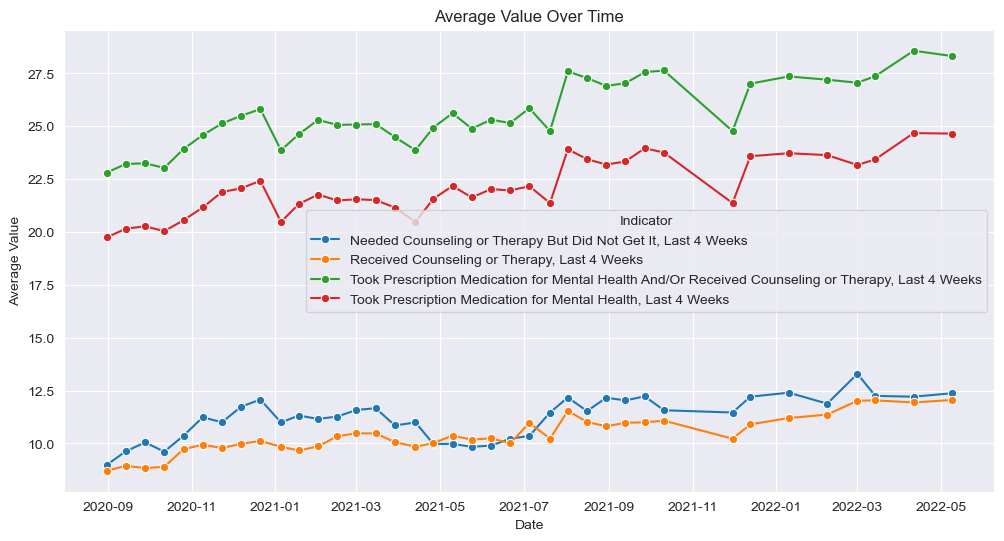

In [51]:
# Calculate mean value over time
df_time = df.groupby(['Time Period End Date', 'Indicator'])['Value'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_time, x='Time Period End Date', y='Value', hue='Indicator', marker='o')
plt.title("Average Value Over Time")
plt.xlabel("Date")
plt.ylabel("Average Value")
plt.show()

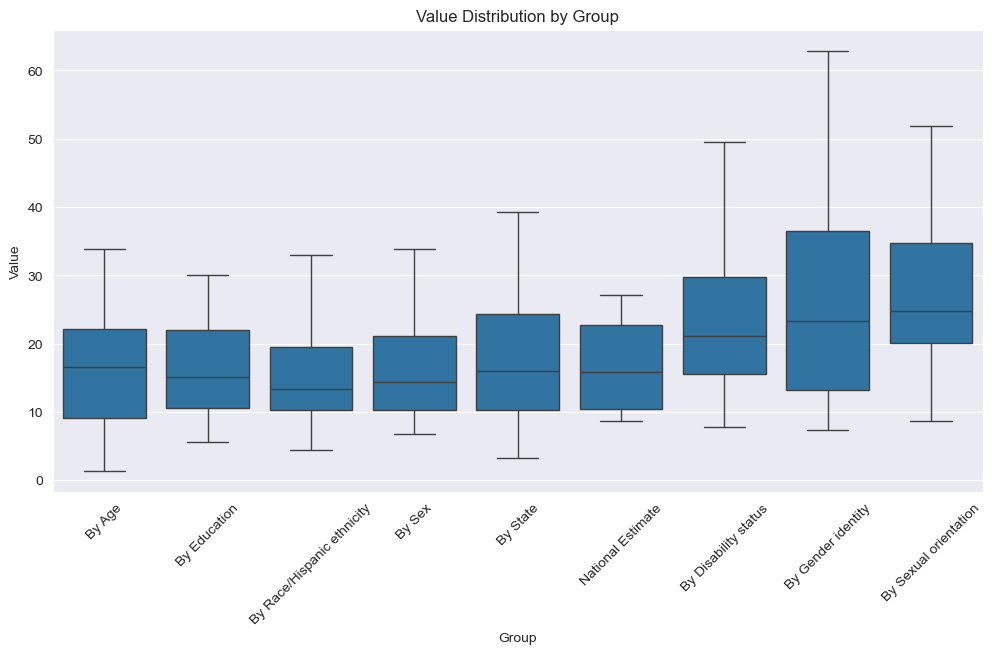

In [52]:
plt.figure(figsize=(12, 6))
temp_df = df[df['Group'] != 'By Presence of Symptoms of Anxiety/Depression']
sns.boxplot(data=temp_df, x='Group', y='Value')
plt.title("Value Distribution by Group")
plt.xticks(rotation=45)
plt.show()

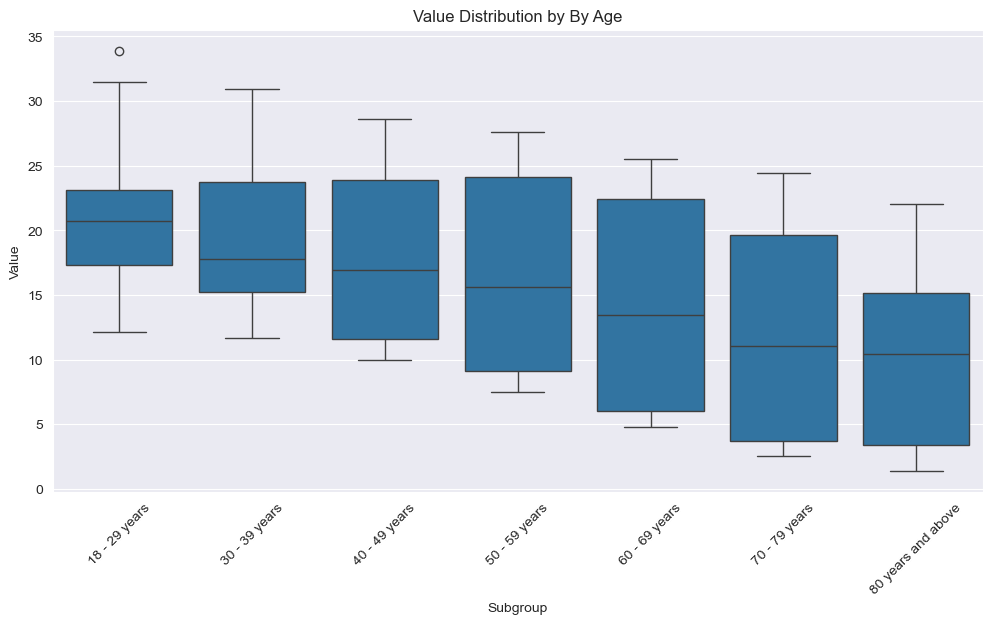

In [53]:
# Boxplot of 'Value' by 'Subgroup' for a specific 'Group'
group_filter = "By Age"  # Change this to explore other groups like 'By Education'
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['Group'] == group_filter], x='Subgroup', y='Value')
plt.title(f"Value Distribution by {group_filter}")
plt.xticks(rotation=45)
plt.show()

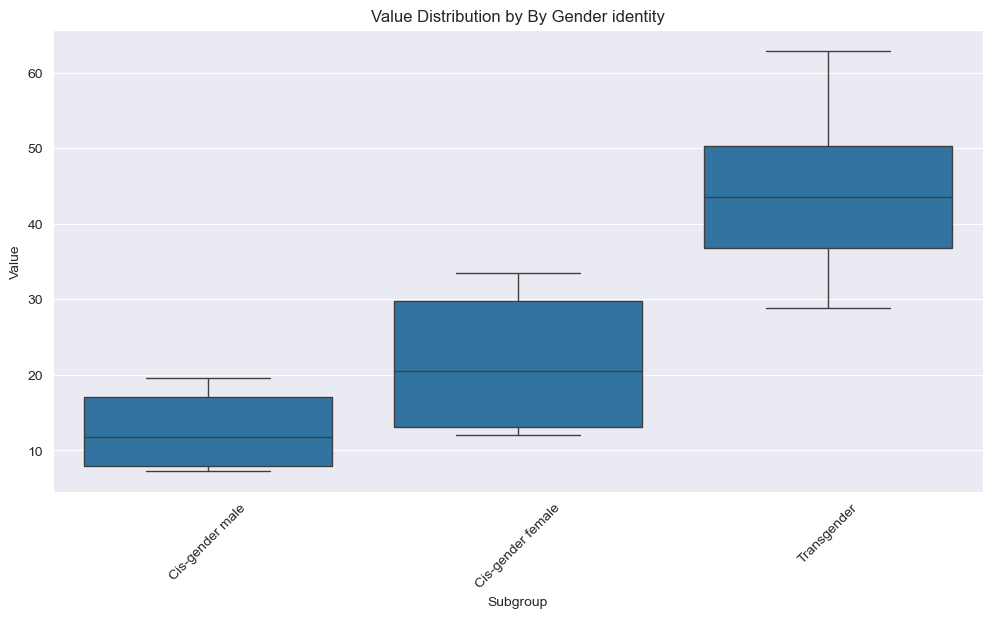

In [57]:
group_filter = "By Gender identity"
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['Group'] == group_filter], x='Subgroup', y='Value')
plt.title(f"Value Distribution by {group_filter}")
plt.xticks(rotation=45)
plt.show()

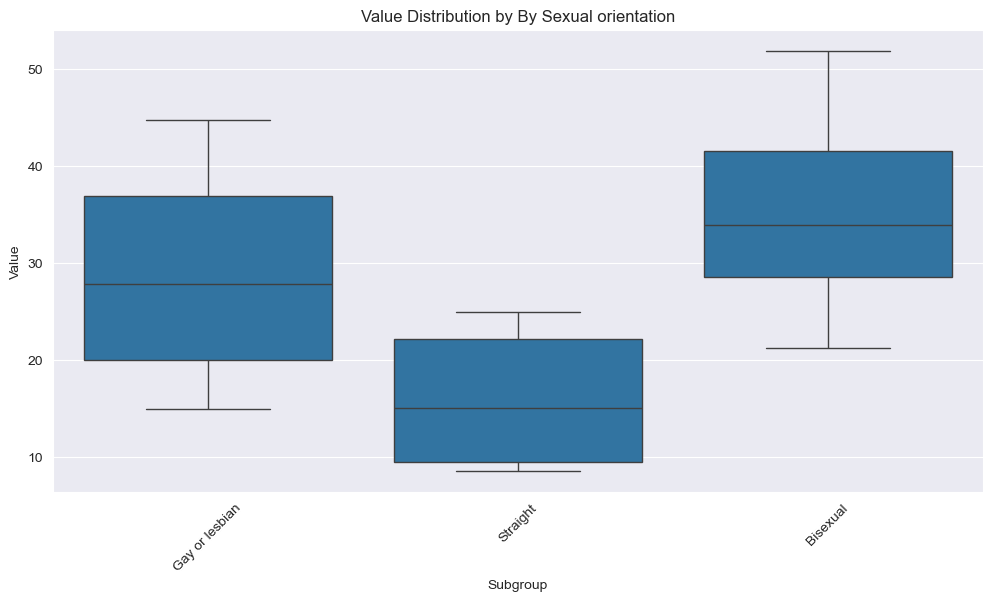

In [59]:
group_filter = "By Sexual orientation"
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['Group'] == group_filter], x='Subgroup', y='Value')
plt.title(f"Value Distribution by {group_filter}")
plt.xticks(rotation=45)
plt.show()

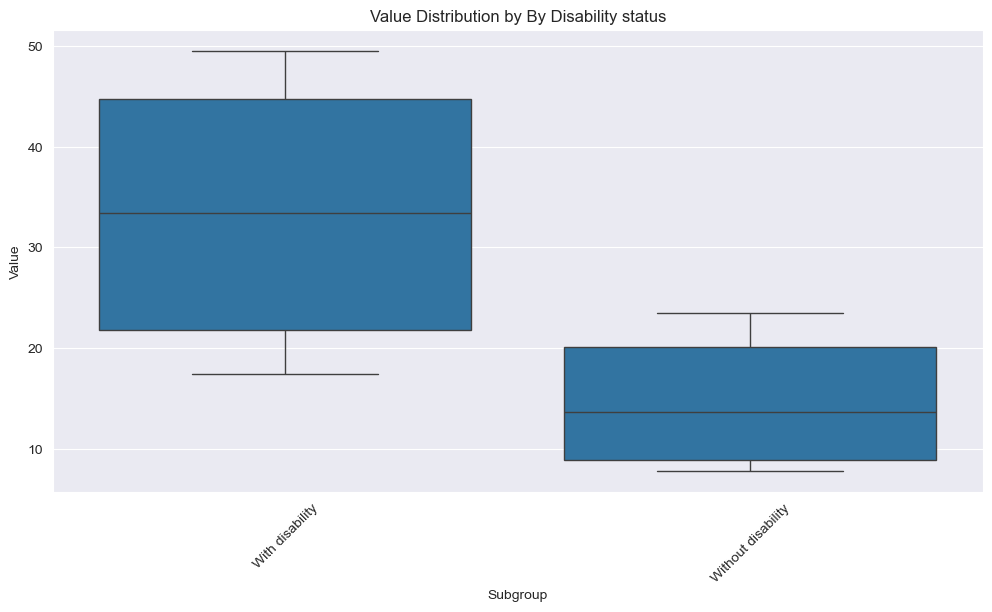

In [58]:
group_filter = "By Disability status"
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['Group'] == group_filter], x='Subgroup', y='Value')
plt.title(f"Value Distribution by {group_filter}")
plt.xticks(rotation=45)
plt.show()

In [55]:
df_non_state = df.drop('State', axis=1)
df_non_state = df_non_state[df_non_state['Group'] != 'By State']
var = 'Group'
df_simple = df_non_state[df_non_state[var] == 'By Education']
df_simple.drop(['Time Period End Date', 'Time Period Start Date', 'Value', var], axis=1, inplace=True)
df_encoded = pd.get_dummies(df_simple, columns=['Subgroup', 'Indicator'], drop_first=True)

C:\Users\rache\AppData\Local\Temp\ipykernel_26724\1890978890.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_simple.drop(['Time Period End Date', 'Time Period Start Date', 'Value', var], axis=1, inplace=True)


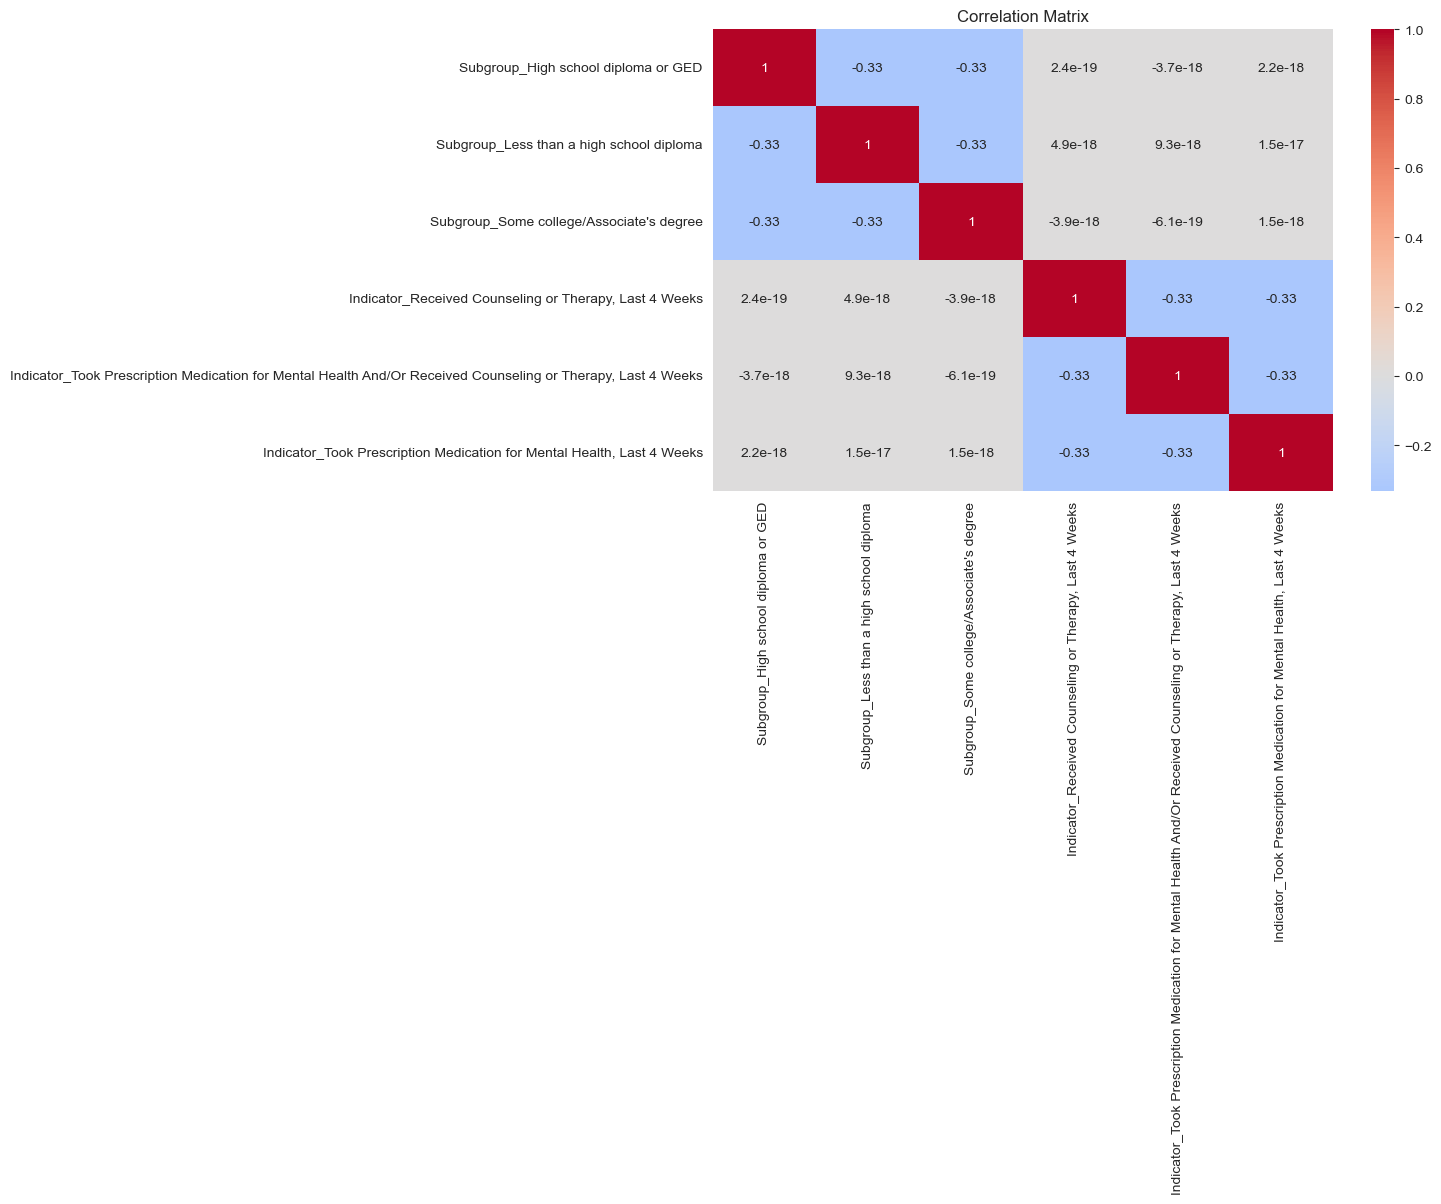

In [56]:
corr = df_encoded.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()